# Lesson 2: Tool Calling
Ref: [deeplearning.ai](https://learn.deeplearning.ai/courses/building-agentic-rag-with-llamaindex/lesson/ix5w5/building-an-agent-reasoning-loop)     
Login with email: ashok@fsm.ac.in (password is the usual one)    
   
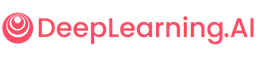

## Setup

In [ ]:
#from helper import get_openai_api_key
#OPENAI_API_KEY = get_openai_api_key()

In [1]:
# 1.0 Needed for parallel I/O processing
import nest_asyncio
nest_asyncio.apply()

## 1. Define a Simple Tool

In [8]:
# 2.0
from llama_index.core.tools import FunctionTool

# Define functions.
# Note that comments within functions are important

# 2.1
def add(x: int, y: int) -> int:
    """Adds two integers together."""
    return x + y

# 2.2
def mystery(x: str, y: str) -> int: 
    """Mystery function that operates on top of two numbers."""
    x = int(x)
    y = int(y)
    return (x + y) * (x + y)


# 2.3
add_tool = FunctionTool.from_defaults(fn=add)
mystery_tool = FunctionTool.from_defaults(fn=mystery)

### Predict and call the tool.
`predict_and_call()` by default uses a `ReAct` agent to do tool calling (through text prompting), but function calling LLMs will implement this differently. It is an `async` function. It can take chat message/history as well.   
Full syntax:    
>apredict_and_call(tools: List[BaseTool], user_msg: Optional[Union[str, ChatMessage]] = None, chat_history: Optional[List[ChatMessage]] = None, verbose: bool = False, **kwargs: Any) -> AgentChatResponse

## What is a ReAct agent    

A "ReACT agent" (short for Reasoning and Acting) is a framework that empowers Large Language Models (LLMs) to solve complex tasks by combining natural language reasoning with the ability to take actions, such as accessing and using tools. 
Here's a more detailed breakdown: 

>    **Reasoning and Acting:**     
    >>ReACT agents alternate between thinking (reasoning) and acting (executing tasks).     

>    **LLM Enhancement:**     
    >>ReACT enhances LLMs by allowing them to not only understand and process information but also take concrete steps based on their understanding.     

>    **Dynamic and Step-by-Step:**         
>>    ReACT agents employ a dynamic, step-by-step approach, starting with a thought, taking an action, and using the result to refine reasoning and decide on the next action.     

>    **Tool Usage:**     
>>    ReACT agents can utilize various tools to interact with external sources (search engines, databases, knowledge bases, etc.) to gather new information and refine their responses.     

>    **Example:**     
>>    Imagine a ReACT agent tasked with finding the tallest building in Bengaluru. It might first reason about the need to search for information, then use a search tool to find relevant data, and finally, use that data to determine the tallest building.     

The reasoning and action agent, abbreviated as the ReACT agent, is a framework that incorporates the reasoning capabilities of LLMs with the ability to take actionable steps. This means they can not only understand and process information but also take concrete steps based on their understanding. These agents can comprehend and process information, assess situations, take apt actions, communicate responses and track ongoing situations. They are, thus, designed to interact with the real world through actions, such as searching the web, accessing databases, or controlling physical devices while leveraging the language abilities of LLMs for planning, decision-making, and knowledge acquisition. (Ref: See [here](https://www.leewayhertz.com/react-agents-vs-function-calling-agents/))

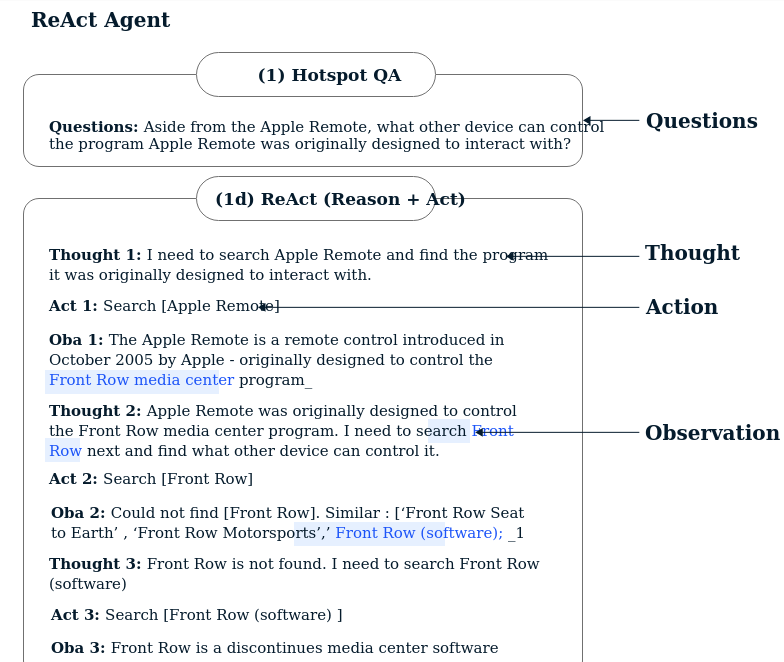

## How do ReACT agents work?

Unlike traditional AI systems that separate decision-making from execution, ReACT agents follow a continuous loop of reasoning and action. Here’s how ReACT agents work:

>    Input: An agent receives a task description in natural language, which is fed into the core LLM.

>    Reasoning: The LLM breaks down the task into smaller steps, analyzes the situation, considers available information and plans the actions required to complete it.

>    Action: Based on the reasoning, the LLM decides which tool to use (e.g., search engine, database, API) and executes actions to gather information or interact with the external environment. This might involve querying Wikipedia for relevant facts or retrieving data from a company database.     

>    Observation: The agent observes the results of the actions and updates its knowledge accordingly. The agent also uses this new information to refine its reasoning in the next iteration.


>    Response: The agent generates a final response based on reasoning and the information gathered.     


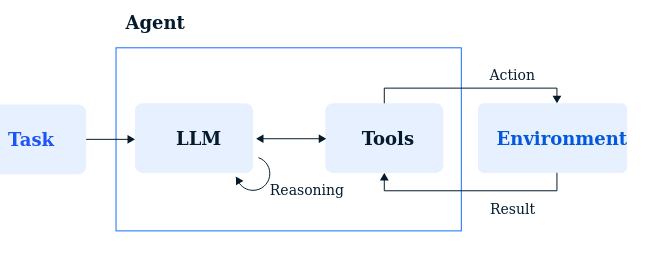

In [10]:
%%time

# 3.0
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.openai_like import OpenAILike

# 3.1
llm = OpenAILike(
                  temperature=0.7,
                  model="gpt-3.5-turbo",                      # Can be any name, not necessarily openai's gpt
                  api_base="http://127.0.0.1:8080/v1",
                  api_key="fake",
                  timeout= 120.0,
                  is_chat_model = True,
                  is_function_calling_model=True,
                  )


# 3.2 Predict which tool to use and then call it
response = llm.predict_and_call(
                                [add_tool, mystery_tool], 
                                "Tell me the output of the mystery function on 2 and 9", 
                                verbose=True
                               )

# 3.3
print(str(response))

=== Calling Function ===
Calling function: mystery with args: {"x": "2", "y": "9"}
=== Function Output ===
121
121
CPU times: user 36.7 ms, sys: 4.06 ms, total: 40.8 ms
Wall time: 11.9 s


Can we use Router: No.
Router engine FunctionTool

In [11]:
# Router engine does not work with FunctionTool object
# 3.4
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector
from llama_index.core import Settings

Settings.llm = llm
# 3.5
# Router takes two arguments:
#                              Which router
#                              NAmes of Query engine tools

query_engine = RouterQueryEngine(
                                 selector=LLMSingleSelector.from_defaults(),
                                 query_engine_tools=[
                                                        add_tool,    # 0
                                                        mystery_tool,     # 1
                                                    ],
                                 verbose=True
                               )

response = query_engine.query("Tell me the output of the mystery function on 2 and 9")
print(str(response))

AttributeError: 'FunctionTool' object has no attribute 'query_engine'

## 2. Define an Auto-Retrieval Tool

### Load Data

To download this paper, below is the needed code:

#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O metagpt.pdf

**Note**: The pdf file is included with this lesson. To access it, go to the `File` menu and select`Open...`.

In [4]:
# 4.0
from llama_index.core import Settings

# 4.1
Settings.llm = OpenAILike(
                          temperature=0.7,
                          model="gpt-3.5-turbo",                      # Can be any name, not necessarily openai's gpt
                          api_base="http://127.0.0.1:8080/v1",
                          api_key="fake",
                          timeout= 120.0,
                          is_chat_model = True,
                          is_function_calling_model=True,
                          )


# 4.2
Settings.embed_model = OllamaEmbedding(
                                        model_name="nomic-embed-text",      # Using foundational model may be overkill
                                        base_url="http://localhost:11434",
                                       )

In [17]:
# 5.0
from llama_index.core import SimpleDirectoryReader


# 5.1 load documents
documents = SimpleDirectoryReader(
                                  input_files=["/home/ashok/Documents/csvrag/metagpt.pdf"]     # List of input files
                                 ).load_data()

In [39]:
from llama_index.core.node_parser import SentenceSplitter
splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [40]:
print(nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: metagpt.pdf
file_path: /home/ashok/Documents/csvrag/metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2025-03-20
last_modified_date: 2025-03-20

Preprint
METAGPT: M ETA PROGRAMMING FOR A
MULTI -AGENT COLLABORATIVE FRAMEWORK
Sirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,
Ceyao Zhang4, Jinlin Wang1, Zili Wang, Steven Ka Shing Yau5, Zijuan Lin4,
Liyang Zhou6, Chenyu Ran1, Lingfeng Xiao1,7, Chenglin Wu1†, J¨urgen Schmidhuber2,8
1DeepWisdom, 2AI Initiative, King Abdullah University of Science and Technology,
3Xiamen University, 4The Chinese University of Hong Kong, Shenzhen,
5Nanjing University, 6University of Pennsylvania,
7University of California, Berkeley, 8The Swiss AI Lab IDSIA/USI/SUPSI
ABSTRACT
Remarkable progress has been made on automated problem solving through so-
cieties of agents based on large language models (LLMs). Existing LLM-based
multi-agent systems can already solve simple dialogue tasks. So

In [41]:
# 6.0
from llama_index.core import VectorStoreIndex

# 6.1
vector_index = VectorStoreIndex(nodes, show_progress = True)
query_engine = vector_index.as_query_engine(similarity_top_k=2)

Generating embeddings: 100%|████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 26.76it/s]


In [42]:
%%time

# 7.0
from llama_index.core.vector_stores import MetadataFilters

# 7.1
query_engine = vector_index.as_query_engine(
                                            similarity_top_k=2,
                                            filters=MetadataFilters.from_dicts(
                                                                                [
                                                                                    {"key": "page_label", "value": "2"}
                                                                                ]
                                                                              )
                                            )

# 7.2
response = query_engine.query(
                                "What are some high-level results of MetaGPT?", 
                             )

In [43]:
print(str(response))

MetaGPT achieves a new state-of-the-art in code generation benchmarks with high scores. It also demonstrates robustness and efficiency, achieving a 100% task completion rate in experimental evaluations. Additionally, it outperforms other popular frameworks for creating complex software projects.


In [44]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': '/home/ashok/Documents/csvrag/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2025-03-20', 'last_modified_date': '2025-03-20'}


### Define the Auto-Retrieval Tool

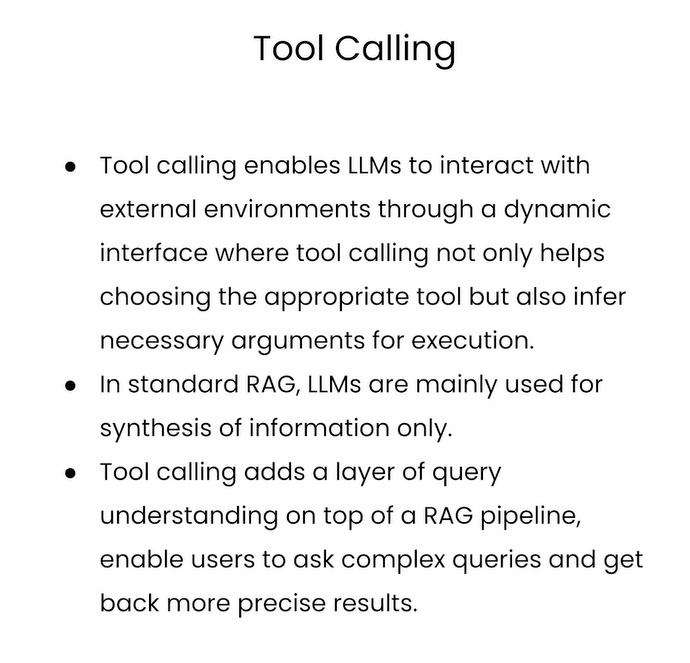

In [53]:
# 8.0
from typing import List
from llama_index.core.vector_stores import FilterCondition

# 8.1
def vector_query(
                 query: str, 
                 page_numbers: List[str]
                ) -> str:
    
    """Perform a vector search over an index.
    
    query (str): the string query to be embedded.
    page_numbers (List[str]): Filter by set of pages. Leave BLANK if we want to perform a vector search
        over all pages. Otherwise, filter by the set of specified pages.
    
    """

    metadata_dicts = [
                       {"key": "page_label", "value": p} for p in page_numbers
                     ]
    
    query_engine = vector_index.as_query_engine(
                                                similarity_top_k=2,
                                                filters=MetadataFilters.from_dicts(
                                                                                   metadata_dicts,
                                                                                   condition=FilterCondition.OR
                                                                                  )
                                             )
    response = query_engine.query(query)
    return response
    



In [54]:
# 9.0
vector_query_tool = FunctionTool.from_defaults(
                                                name="vector_tool",
                                                fn=vector_query
                                               )

In [55]:
%%time

# 9.1

llm = Settings.llm
response = llm.predict_and_call(
                                [vector_query_tool], 
                               "What are the high-level results of MetaGPT as described on page 2?", 
                                verbose=True
                               )

=== Calling Function ===
Calling function: vector_tool with args: {"page_numbers": ["2"], "query": "What are the high-level results of MetaGPT?"}
=== Function Output ===
MetaGPT demonstrates exceptional performance in code generation benchmarks, achieving state-of-the-art results with high Pass@1 scores. It excels in handling complex software projects, offering extensive functionality and maintaining a 100% task completion rate in experimental evaluations. This highlights its robustness and efficiency in design and execution.


In [56]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': '/home/ashok/Documents/csvrag/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2025-03-20', 'last_modified_date': '2025-03-20'}


## Let's add some other tools!

In [ ]:
from llama_index.core import SummaryIndex
from llama_index.core.tools import QueryEngineTool

summary_index = SummaryIndex(nodes)
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
summary_tool = QueryEngineTool.from_defaults(
    name="summary_tool",
    query_engine=summary_query_engine,
    description=(
        "Useful if you want to get a summary of MetaGPT"
    ),
)

In [ ]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What are the MetaGPT comparisons with ChatDev described on page 8?", 
    verbose=True
)

In [ ]:
for n in response.source_nodes:
    print(n.metadata)

In [ ]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What is a summary of the paper?", 
    verbose=True
)